## Import libraris

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('../')
from utilities.ML_algorithms import create_RF_model, create_XGB_model, create_ANN_model
from utilities.plot_results import plot_prediction, plot_scores, plot_feature_importance

## Read data train

In [2]:
cs_file = '../data/SMB_input_four_ERA5.csv'

df_train = pd.read_csv(cs_file, delimiter='\t', index_col=['Date'], parse_dates=['Date'], na_values='NAN')


## Relabel stakes

In [3]:
df_train.reset_index(inplace=True)
df_train = df_train.sort_values(by = ['Elevation', 'Date'], ascending=True).reset_index()

In [4]:
label_stake = df_train.drop_duplicates(subset=['Elevation']).reset_index()[['Elevation', 'Stake']]
label_stake

,Elevation,Stake
0,96.8,PG19
1,121.0,PG09
2,131.4,PG18
3,159.1,PG08
4,167.2,PG17
5,188.6,PG07
6,194.5,PG16_AWS
7,223.7,PG06
8,229.4,PG16
9,247.9,PG05


In [5]:
label_stake_mod = label_stake.copy()
label_stake_mod.index = label_stake_mod['Elevation']
range_elev = np.arange(90,470, 30)
range_elev[-1]  = range_elev[-1] + 30
range_elev1 =range_elev[0:8]
range_elev1[-1] = range_elev[-1]
range_elev1

array([ 90, 120, 150, 180, 210, 240, 270, 480])

In [6]:
grupos_ele = []
for i in range(len(range_elev1)-1):
    print(i)
    grupos_ele.append(label_stake_mod.loc[range_elev1[i]:range_elev1[i+1]])

0
1
2
3
4
5
6


In [7]:
for i in range(len(grupos_ele)):
    df_train['Stake'].replace(grupos_ele[i]['Stake'].values.tolist(), 'G'+str(i), inplace = True)

In [8]:
#print(df_train)

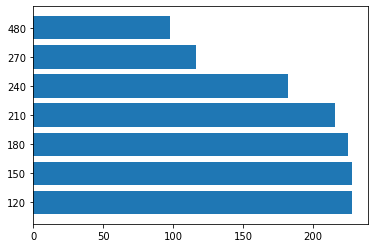

In [9]:
fig, ax = plt.subplots()
ax.barh(np.arange(len(range_elev1)-1), df_train['Stake'].value_counts().values)
ax.set_yticks(np.arange(len(range_elev1)-1))
ax.set_yticklabels(range_elev1[1:])
print()

In [10]:
label_stake = df_train.drop_duplicates(subset=['Stake']).reset_index(drop=True)[['Stake']]
label_stake

,Stake
0,G0
1,G1
2,G2
3,G3
4,G4
5,G5
6,G6


## Folds to train

In [11]:
n_folds = 7
prng = np.random.RandomState(1)
random_stake1 = prng.randint(0, len(label_stake), n_folds) # Random glacier indexes
prng = np.random.RandomState(2021)
random_stake2 = prng.randint(0, len(label_stake), n_folds) # Random glacier indexes

index_test = np.stack((random_stake1, random_stake2), axis=1)
index_test

array([[5, 4],
       [3, 5],
       [4, 1],
       [0, 0],
       [1, 5],
       [3, 6],
       [5, 6]])

### Create matrix of indexes (N folds)

In [12]:
custom_cv = []
for i in range(len(index_test)):
    data_train_index = df_train.loc[df_train['Stake'].isin(label_stake.drop(index_test[i])['Stake'].values)]
    data_test_index  = df_train.loc[df_train['Stake'].isin(label_stake.loc[index_test[i]]['Stake'].values)]
    custom_cv.append((np.array(data_train_index.index), np.array(data_test_index.index)))

## Read data test

In [13]:
cs_file = '../data/SMB_input_belli_ERA5.csv'
df_test = pd.read_csv(cs_file, delimiter='\t', index_col=['Date'], parse_dates=['Date'], na_values='NAN')
features_to_drop = ['Stake', 'Latitude','Longitude', 'SMB']
X_test = (df_test.drop(features_to_drop, axis=1)).to_numpy()
y_test = (df_test['SMB'].copy()).to_numpy()

## Convert train dataframe to array

In [14]:
features_to_drop = ['index','Date', 'Stake', 'Latitude','Longitude', 'SMB']

df_train_X = (df_train.drop(features_to_drop, axis=1)) 
X = (df_train.drop(features_to_drop, axis=1)).to_numpy()
y = (df_train['SMB'].copy()).to_numpy()


## Lasso train

In [15]:
cv_model_lasso = LassoCV(cv=custom_cv).fit(X, y)

### Evaluation Lasso with glaciar test data (Bellin)

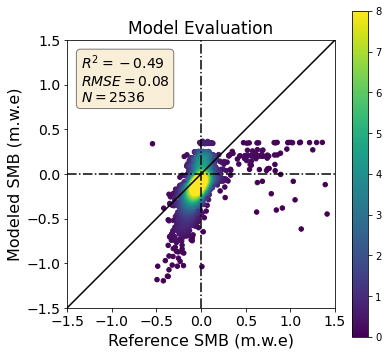

In [16]:
plot_prediction(y_test, cv_model_lasso.predict(X_test), len(y_test), n_toplot=5000 )
print()

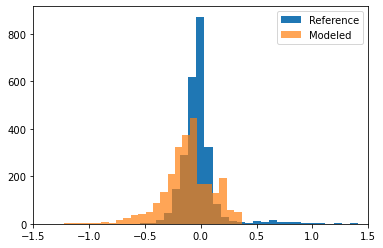

In [17]:
plt.hist(y_test, bins=50, label='Reference')
plt.hist(cv_model_lasso.predict(X_test), bins=50, alpha=0.7,  label='Modeled')
plt.xlim(-1.5, 1.5)
plt.legend()

## RF train

In [18]:
RF_model = create_RF_model(custom_cv).fit(X, y)

In [19]:
RF_model.best_params_

{'n_estimators': 300, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 8}

### Evaluation RF with glaciar test data (Bellin)

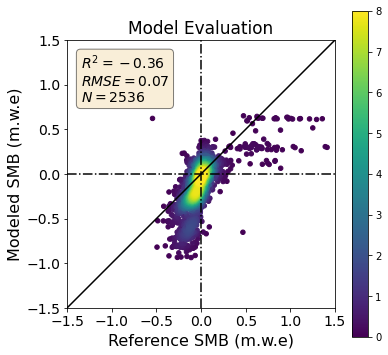

In [20]:
fig = plot_prediction(y_test, RF_model.predict(X_test), len(y_test), n_toplot=5000 )

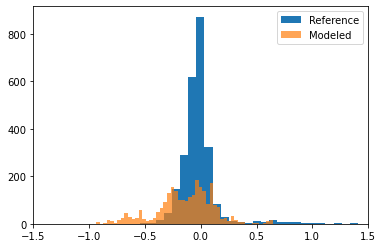

In [21]:
plt.hist(y_test, bins=50, label='Reference')
plt.hist(RF_model.predict(X_test), bins=50, alpha=0.7,  label='Modeled')
plt.xlim(-1.5, 1.5)
plt.legend()

<Figure size 432x216 with 0 Axes>

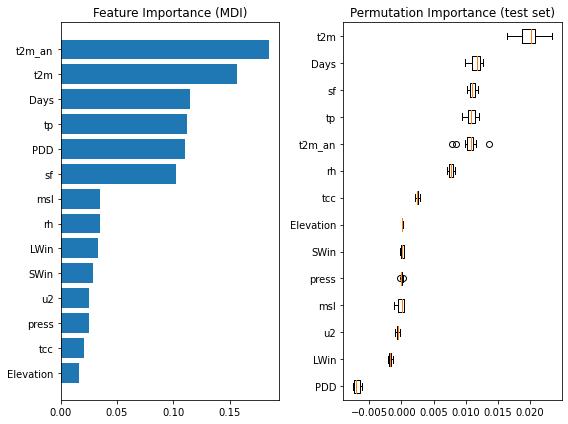

In [22]:
fig = plot_feature_importance(RF_model, df_train_X, X_test, y_test)

## XGBoot train

In [23]:
XGB_model = create_XGB_model(custom_cv).fit(X, y)

In [24]:
XGB_model.best_params_

{'n_estimators': 400,
 'min_samples_leaf': 5,
 'max_features': 12,
 'max_depth': 8}

### Evaluation XGBoot with glaciar test data (Bellin)

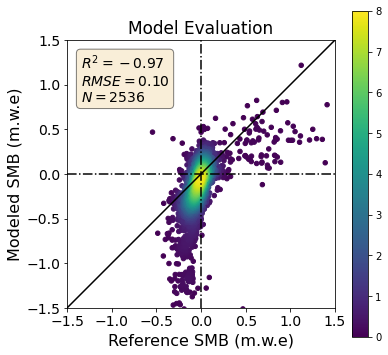

In [25]:
fig = plot_prediction(y_test, XGB_model.predict(X_test), len(y_test), n_toplot=5000 )

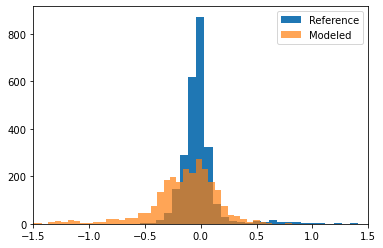

In [26]:
plt.hist(y_test, bins=50, label='Reference')
plt.hist(XGB_model.predict(X_test), bins=50, alpha=0.7,  label='Modeled')
plt.xlim(-1.5, 1.5)
plt.legend()

<Figure size 432x216 with 0 Axes>

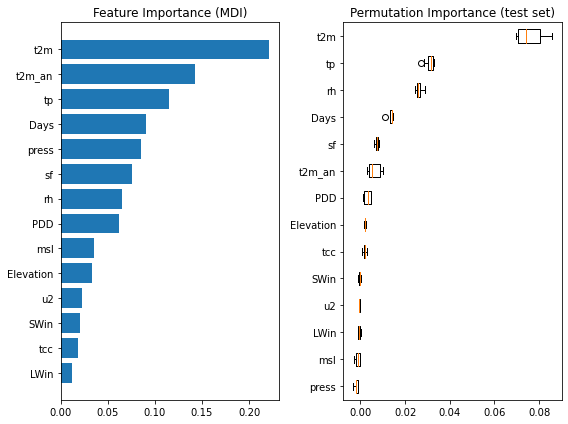

In [27]:
fig = plot_feature_importance(XGB_model, df_train_X, X_test, y_test)

## Train ANNs

In [28]:
scaler = StandardScaler().fit(X)
ANN_model = create_ANN_model(custom_cv).fit(scaler.transform(X), y)

/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/christian/miniconda3/envs/DL_SMB/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Conv

In [29]:
ANN_model.best_params_

{'validation_fraction': 0.001,
 'solver': 'lbfgs',
 'shuffle': False,
 'max_iter': 200,
 'learning_rate': 'constant',
 'hidden_layer_sizes': 10,
 'batch_size': 150,
 'alpha': 0.0005,
 'activation': 'tanh'}

### Evaluation ANN with glaciar test data (Bellin)

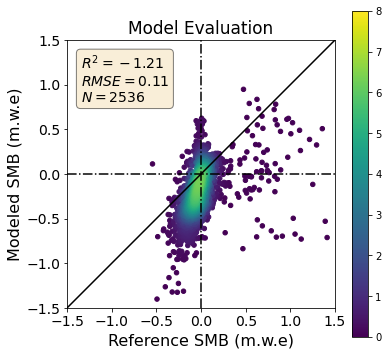

In [30]:
fig = plot_prediction(y_test, ANN_model.predict(scaler.transform(X_test)), len(y_test), n_toplot=5000)

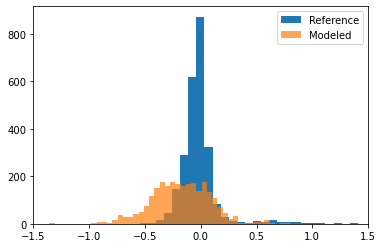

In [31]:
plt.hist(y_test, bins=50, label='Reference')
plt.hist(ANN_model.predict(scaler.transform(X_test)), bins=50, alpha=0.7,  label='Modeled')
plt.xlim(-1.5, 1.5)
plt.legend()

In [32]:
#plot_feature_importance(MLP_gridCV, df_train_X, X_test, y_test)
#print()